In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
rcParams['figure.figsize'] = 16,8
sns.set(rc={'figure.figsize':(16,8)})

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
class Handler:

    def __init__(self):
        self.max_open_cred_spam = None
        self.cur_loan_spam = None
        self.model = None
        self.columns_int = ['Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems',
                            'Bankruptcies', 'Months since last delinquent', 'Tax Liens']
        self.cat_columns = ['Home Ownership', 'Years in current job', 'Purpose']
        
        self.columns_for_ann_inc = ['Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance',
                                    'Monthly Debt', 'Annual Income']
        self.ann_inc = 'Annual Income'

        self.train_prep = None
        self.test_prep = None
    
    def _filling_null_columns(self, df, columns, target_column):

        print('-' * 100)
        print(f'Filling {target_column}\n')
        test = df[df[target_column].notna()][columns]
        target = df[df[target_column].isna()][columns].drop(target_column, axis=1)
        print(f'Test sample size: {test.shape}\nTrain sample size: {target.shape}')
        
        X = test.drop(target_column, axis=1)
        y = test[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        parameters_for_GSCV = [{'n_estimators': range(50, 550, 50),
                                'max_features': range(1, len(columns)),
                                'max_depth': range(1, 50),
                                'min_samples_leaf': range(1, 30)}]
        cv = KFold(n_splits=3, random_state=42, shuffle=True)

        rs = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                                *parameters_for_GSCV,
                                scoring='r2',
                                cv=cv,
                                n_jobs=-1)
        rs.fit(X_train, y_train)
        y_pred = rs.predict(X_test)
        print(f'r2 score for {target_column} prediction: {r2_score(y_test, y_pred)}')
        rs.fit(X, y)
        pred_data = rs.predict(target)
        print('-' * 100)
        return rs, pred_data

    def fit_transform(self, data):
        
        print(f'Data shape: {data.shape}')
        data.drop('Id', axis=1, inplace=True)
        self.max_open_cred_spam = data['Maximum Open Credit'].quantile(0.995)
        data.loc[(data['Maximum Open Credit'] > self.max_open_cred_spam),'Maximum Open Credit'] = self.max_open_cred_spam
        data['Bankruptcies'].fillna(0, inplace=True)
        data['Credit Score'].fillna(0, inplace=True)
        data['Term'] = data['Term'].astype('category').cat.codes
        self.cur_loan_spam = data['Current Loan Amount'].quantile(0.88)
        data.loc[(data['Current Loan Amount'] > self.cur_loan_spam), 'Current Loan Amount'] = self.cur_loan_spam

        self.model, pred_data = self._filling_null_columns(data, self.columns_for_ann_inc, self.ann_inc)

        data.loc[data[self.ann_inc].isnull(), self.ann_inc] = pred_data

        data.loc[(data['Credit Score'] > 10), 'Months since last delinquent'] = 0
        data['Months since last delinquent'].fillna(12, inplace=True)

        data['Years in current job'].fillna('1 year', inplace=True)

        data[self.columns_int] = data[self.columns_int].astype('int32')

        for column_name in self.cat_columns:
            data[column_name] = data[column_name].astype(str)

        for cat_colname in data.select_dtypes(include='object').columns:
            data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)

        self.train_prep = data.drop(self.cat_columns, axis=1)

    def transform(self, data):

        print(f'Data shape: {data.shape}')
        data.drop('Id', axis=1, inplace=True)
        data.loc[(data['Maximum Open Credit'] > self.max_open_cred_spam), 'Maximum Open Credit'] = self.max_open_cred_spam
        data['Bankruptcies'].fillna(0, inplace=True)
        data['Credit Score'].fillna(0, inplace=True)
        
        data['Term'] = data['Term'].astype('category').cat.codes
        
        data.loc[(data['Current Loan Amount'] > self.cur_loan_spam), 'Current Loan Amount'] = self.cur_loan_spam

        target = data[data[self.ann_inc].isna()][self.columns_for_ann_inc].drop(self.ann_inc, axis=1)

        pred_data = self.model.predict(target)
        data.loc[data[self.ann_inc].isnull(), self.ann_inc] = pred_data

        data.loc[(data['Credit Score'] > 10), 'Months since last delinquent'] = 0
        data['Months since last delinquent'].fillna(12, inplace=True)
        data['Months since last delinquent'] = data['Months since last delinquent'].astype('int32')

        data['Years in current job'].fillna('1 year', inplace=True)

        cat_columns = ['Home Ownership', 'Years in current job', 'Purpose']

        data[self.columns_int] = data[self.columns_int].astype('int32')

        for column_name in self.cat_columns:
            data[column_name] = data[column_name].astype(str)

        for cat_colname in data.select_dtypes(include='object').columns:
            data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)
        
        data['Purpose_renewable energy'] = 0
        
        self.test_prep = data.drop(cat_columns, axis=1)

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

---

---

## Шаг 1:
***Загрузка данных***

In [5]:
data = pd.read_csv('train.csv')
data.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

Количество пропусков в данных

In [7]:
data.isnull().sum(axis = 0)

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

---

---

## Шаг 2:
***Изучение данных***

**Home Ownership**

In [8]:
data['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

Колонка с категориальным пизнаком и без пропусков, применим one-hot-кодирование

---

**Annual Income**

<Figure size 1080x576 with 0 Axes>

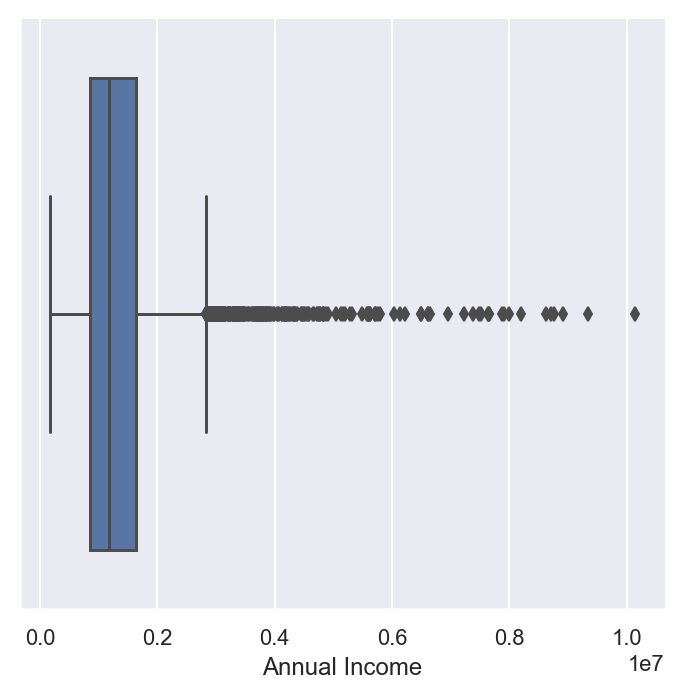

In [9]:
plt.figure(figsize=(15,8))
sns.catplot(x="Annual Income", kind = "box", data=data)

Признак имеет множество пропусков и требует тщательного заполнения.

Заполним его из признаков, имеющих с ним значимую корреляцию, при помощи регрессионной модели.

---

**Years in current job**

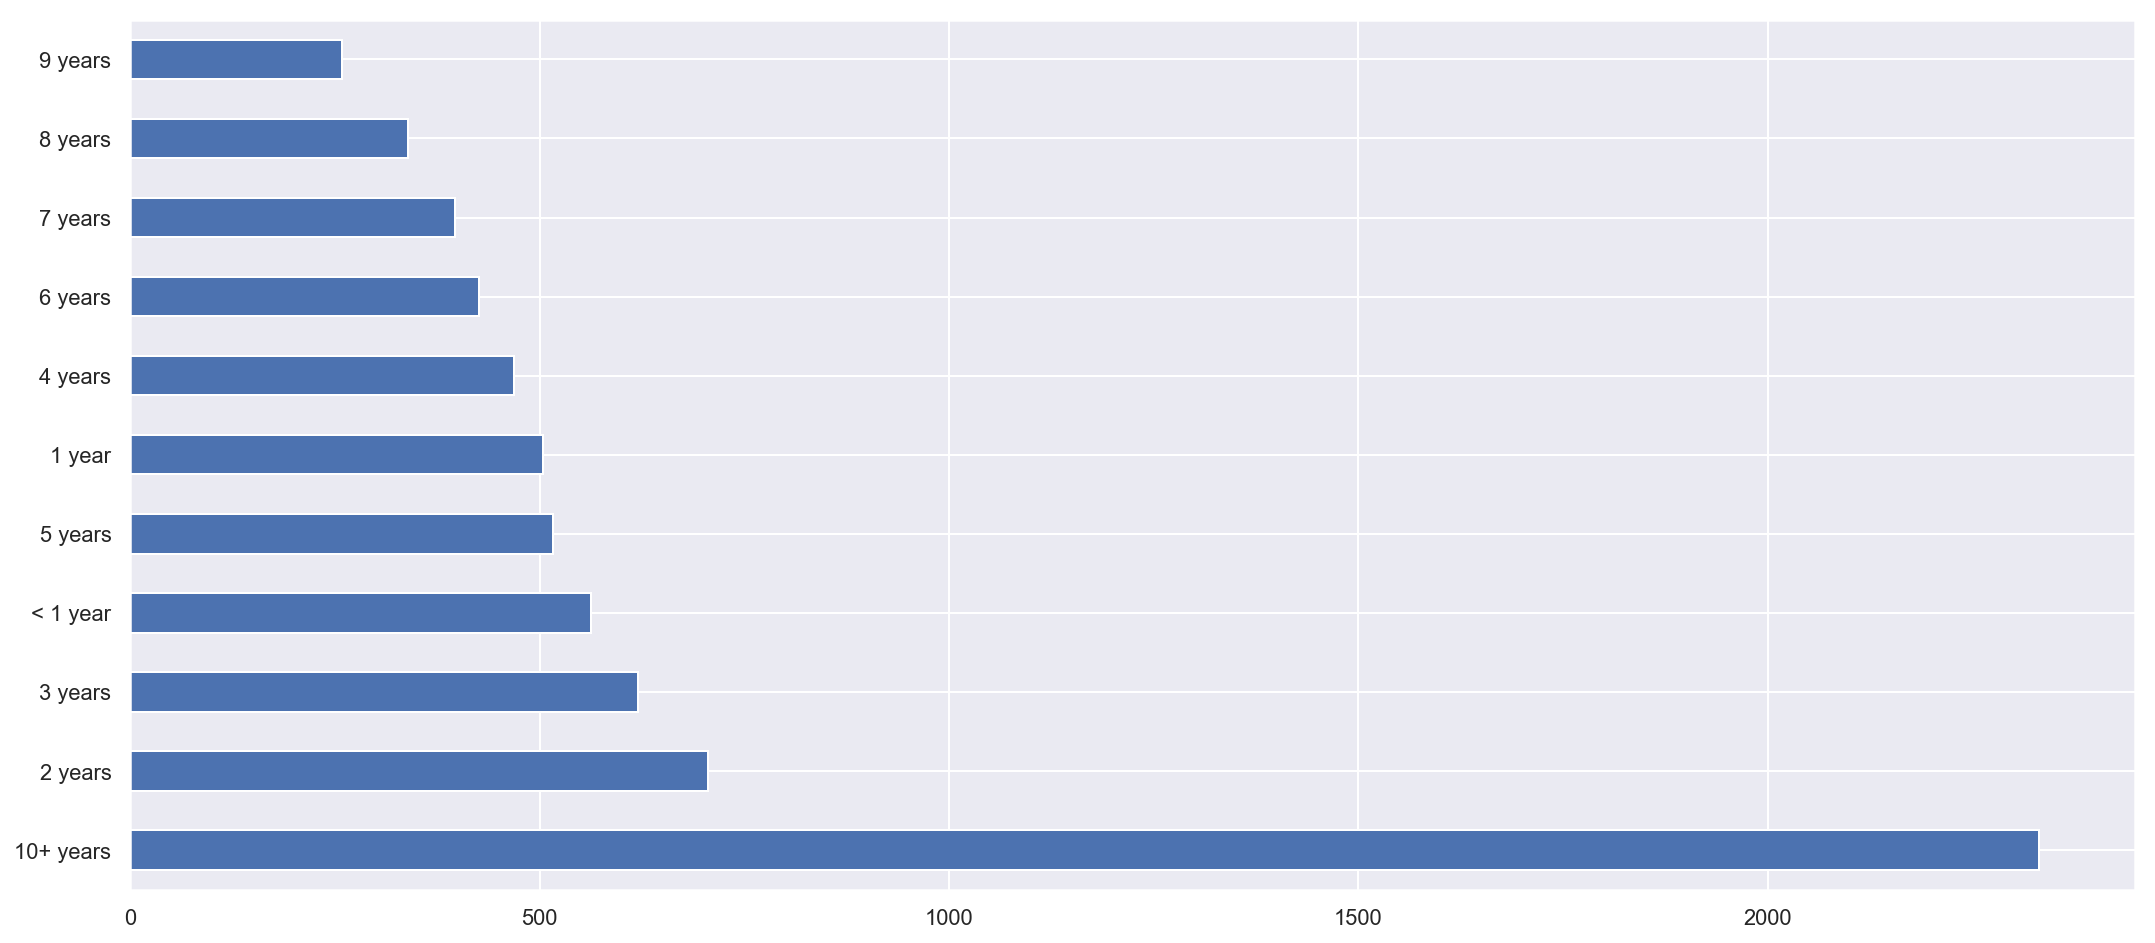

In [10]:
data['Years in current job'].value_counts().plot(kind='barh')

In [11]:
data['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Пропуски заполним значанием: 1 year

Категориальные признак, применим one-hot-кодирование

---

**Tax Liens**

In [12]:
data['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Тут все хорошо, числовой признак

---

**Number of Open Accounts**

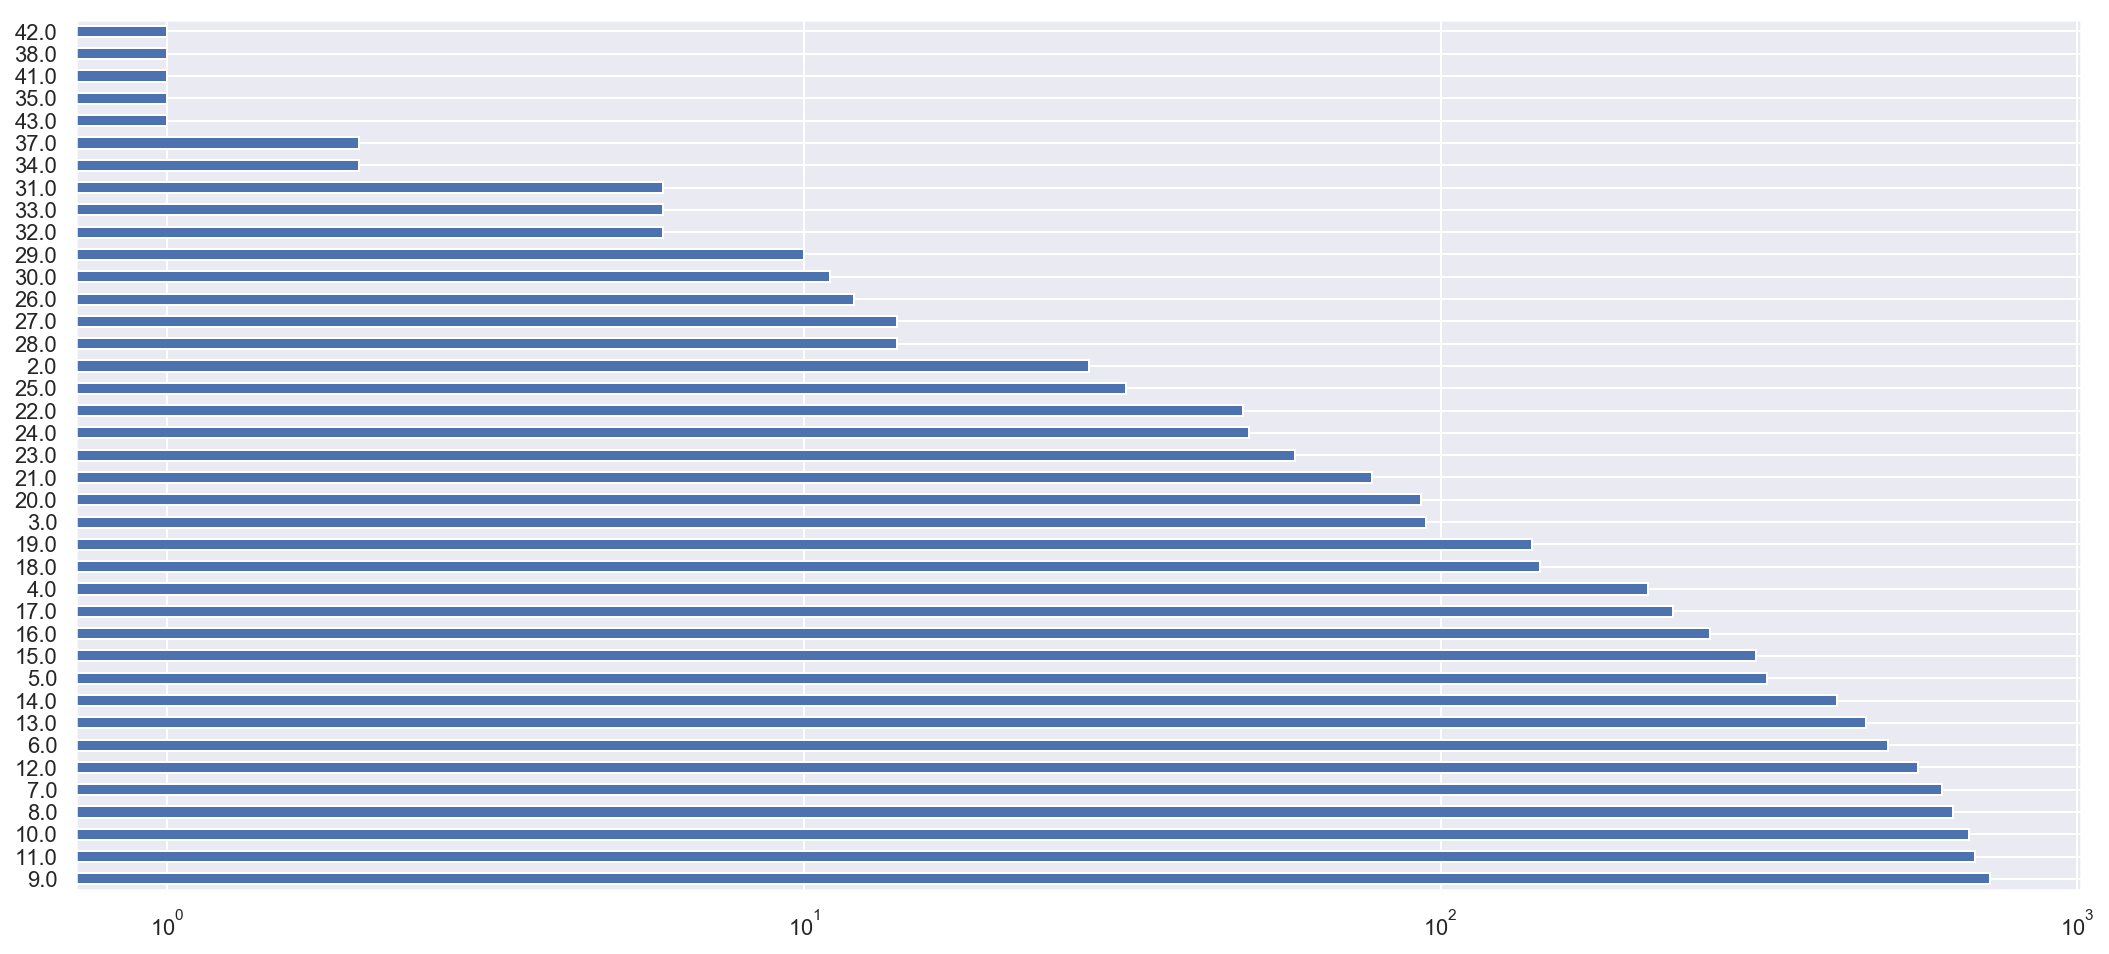

In [13]:
data['Number of Open Accounts'].value_counts().plot(kind='barh', logx=True)

Нормальные данные, числовой признак

----

**Years of Credit History**

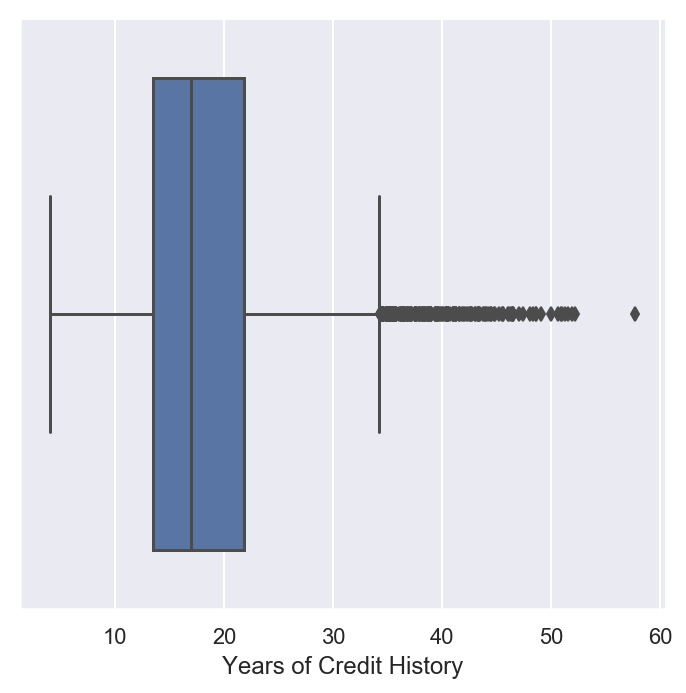

In [14]:
sns.catplot(x="Years of Credit History", kind = "box", data=data)

Все замечательно

---

**Maximum Open Credit**

In [15]:
data.describe()['Maximum Open Credit']

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

Построим график, зависимости признака от количества людей

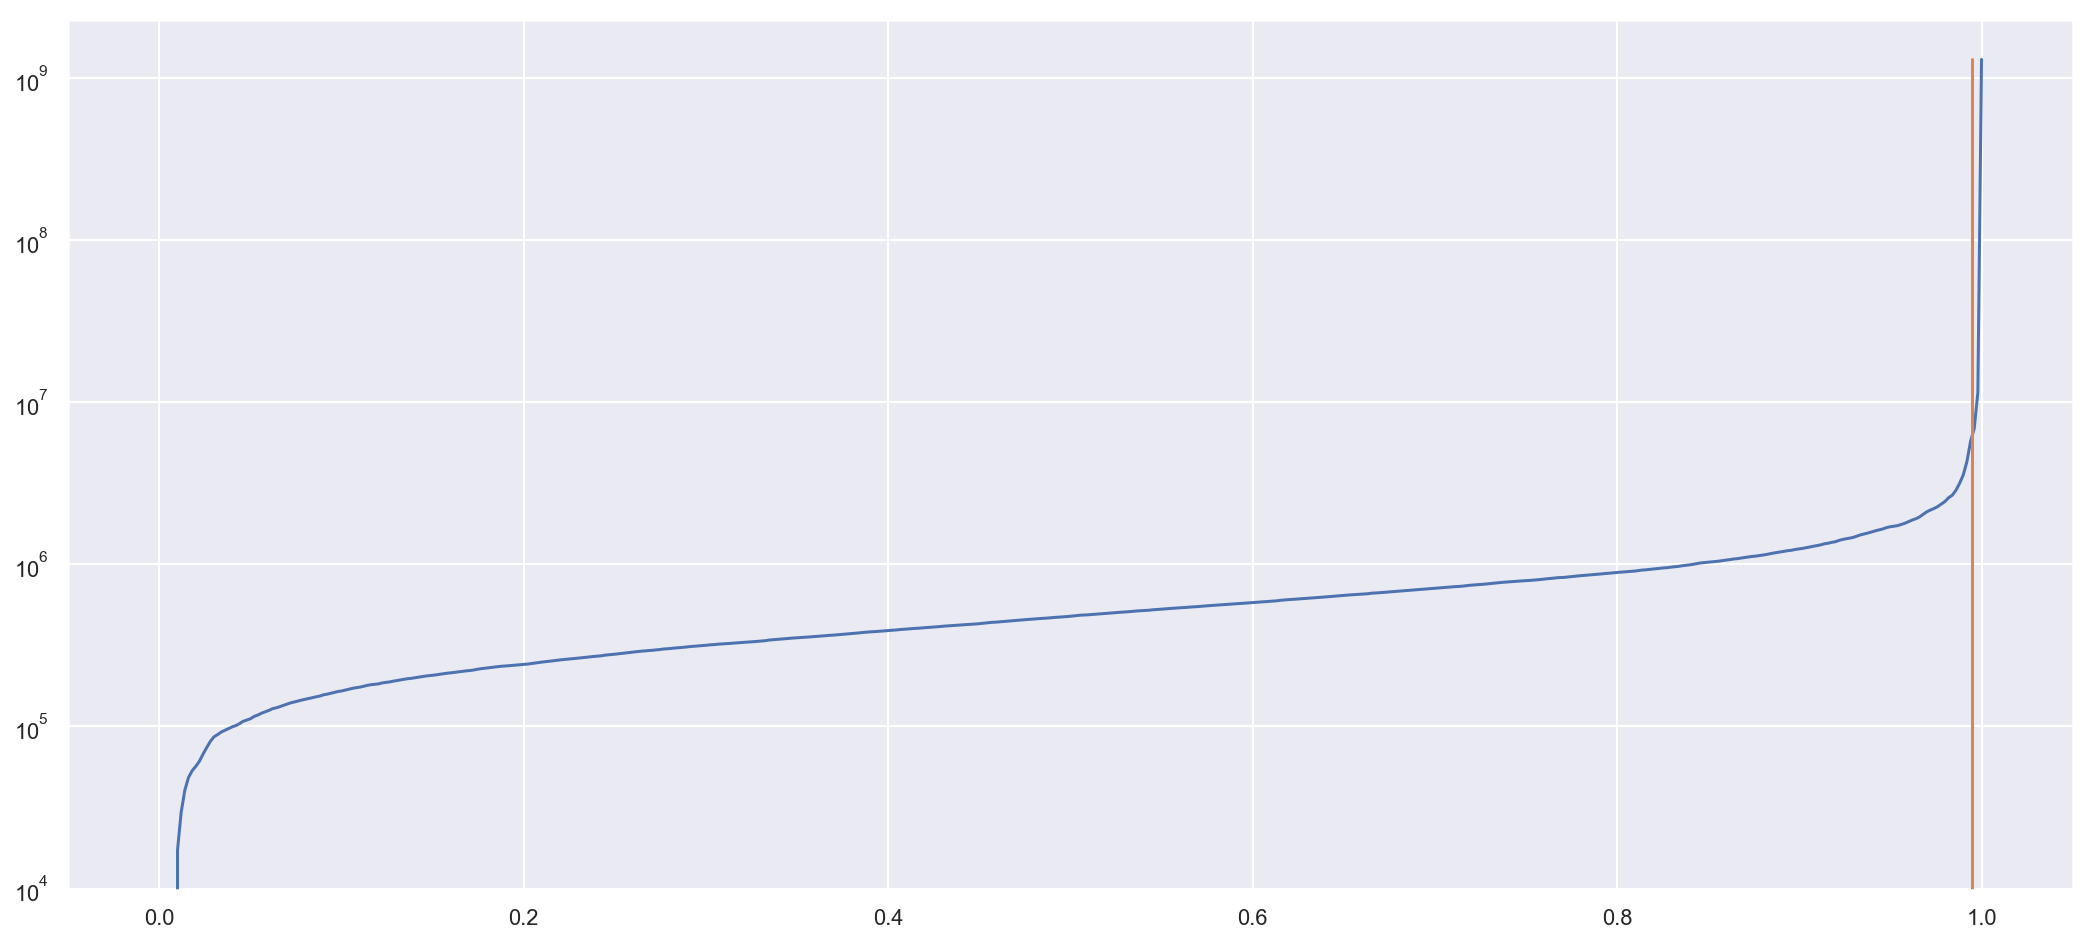

In [16]:
x = np.linspace(0,1,500)
plt.plot(x, [data['Maximum Open Credit'].quantile(x) for x in x])
plt.plot([0.995,0.995], [0, data['Maximum Open Credit'].max()])
plt.yscale('log')

Сомневаюсь в правдивости информации более 99,5 процентиля

---

**Number of Credit Problems**

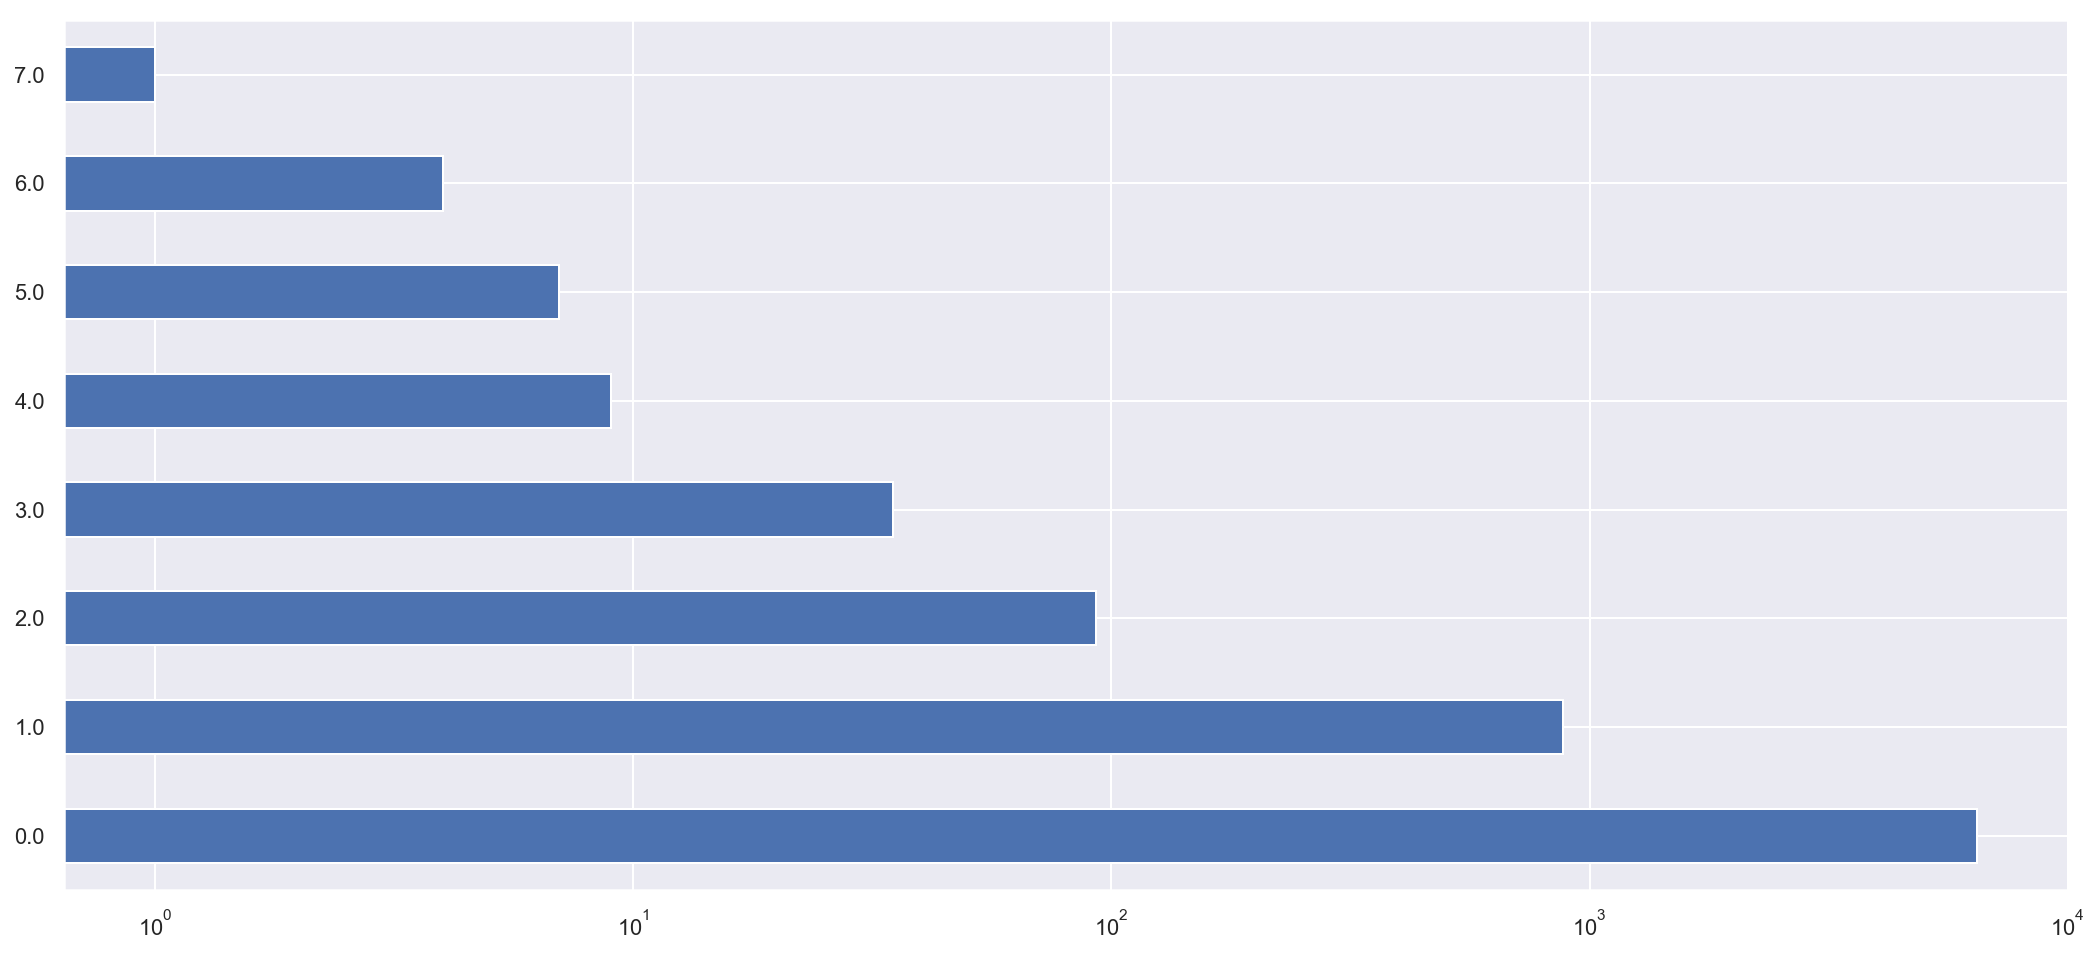

In [17]:
data['Number of Credit Problems'].value_counts().plot(kind='barh', logx=True)

Тут все отлично

---

**Months since last delinquent**

In [18]:
data[data['Months since last delinquent'].isna()]['Number of Credit Problems'].value_counts()

0.0    3557
1.0     468
2.0      38
3.0      15
4.0       3
Name: Number of Credit Problems, dtype: int64

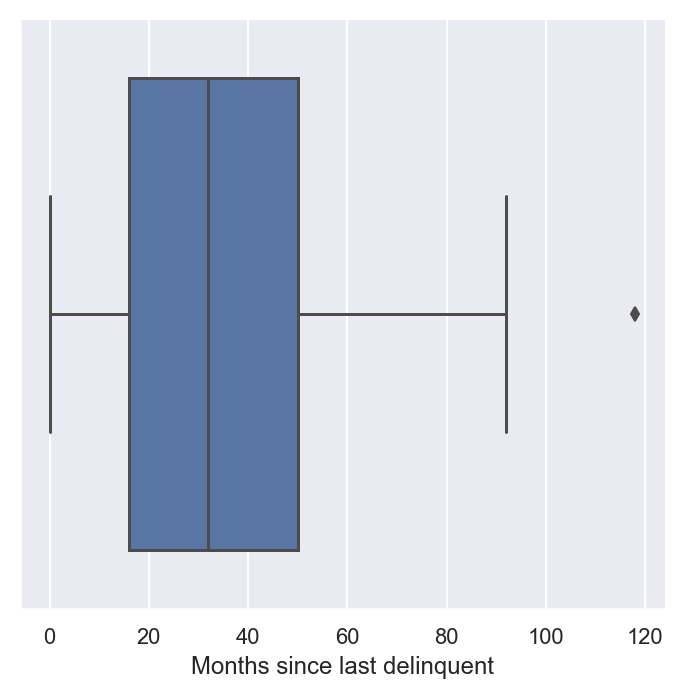

In [19]:
sns.catplot(x="Months since last delinquent", kind = "box", data=data)

Заполним 0 там где положительный Credit Score

По другим заполним значением 12

---

**Bankruptcies**

In [20]:
data['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Зполним пропуски нулями

---

**Purpose**

In [21]:
data['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Обычный категориальный признак, применим one-hot-кодирование

---

**Term**

In [22]:
data['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Бинарный категориальрный признак

---

**Current Loan Amount**

In [23]:
data['Current Loan Amount'].quantile(0.88)

785872.5599999999

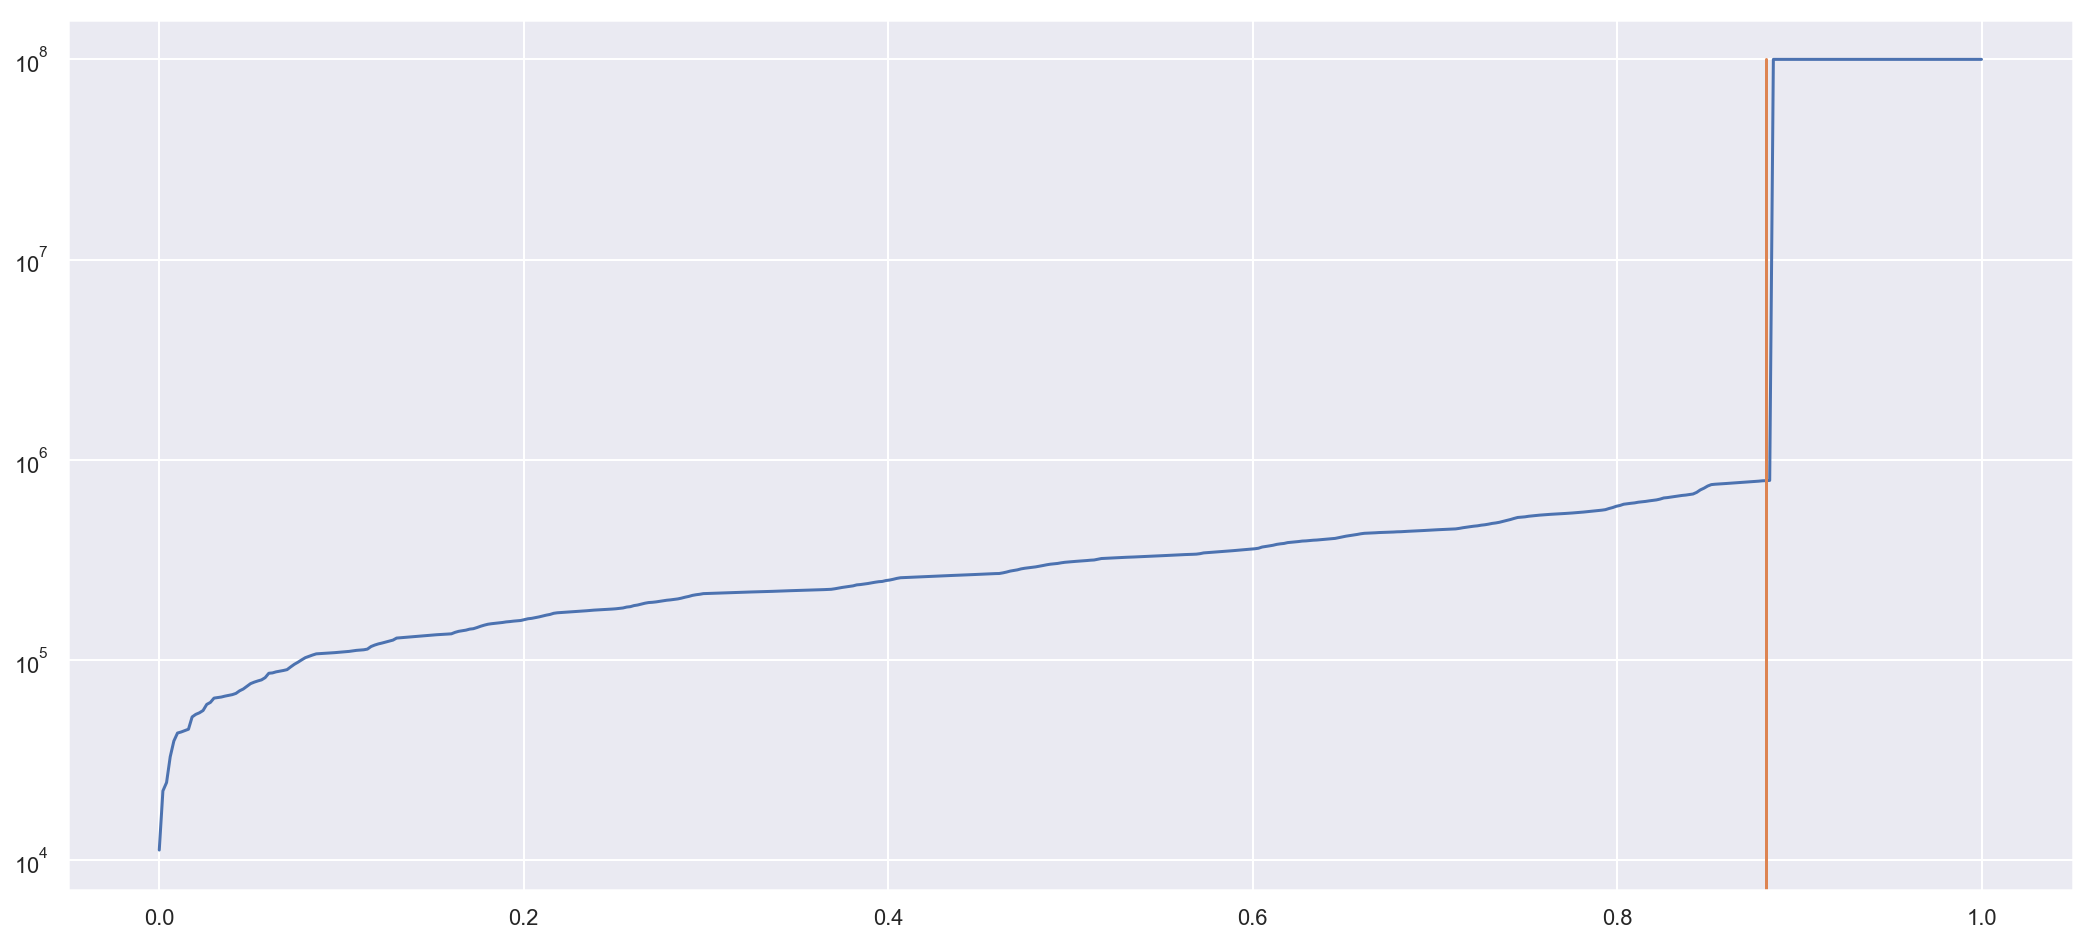

In [24]:
x = np.linspace(0,1,500)
plt.plot(x, [data["Current Loan Amount"].quantile(x) for x in x])
plt.plot([0.882,0.882], [0, data["Current Loan Amount"].max()])
plt.yscale('log')

Заполним выбросы на уровнее 88,2 процентиля

---

**Current Credit Balance**

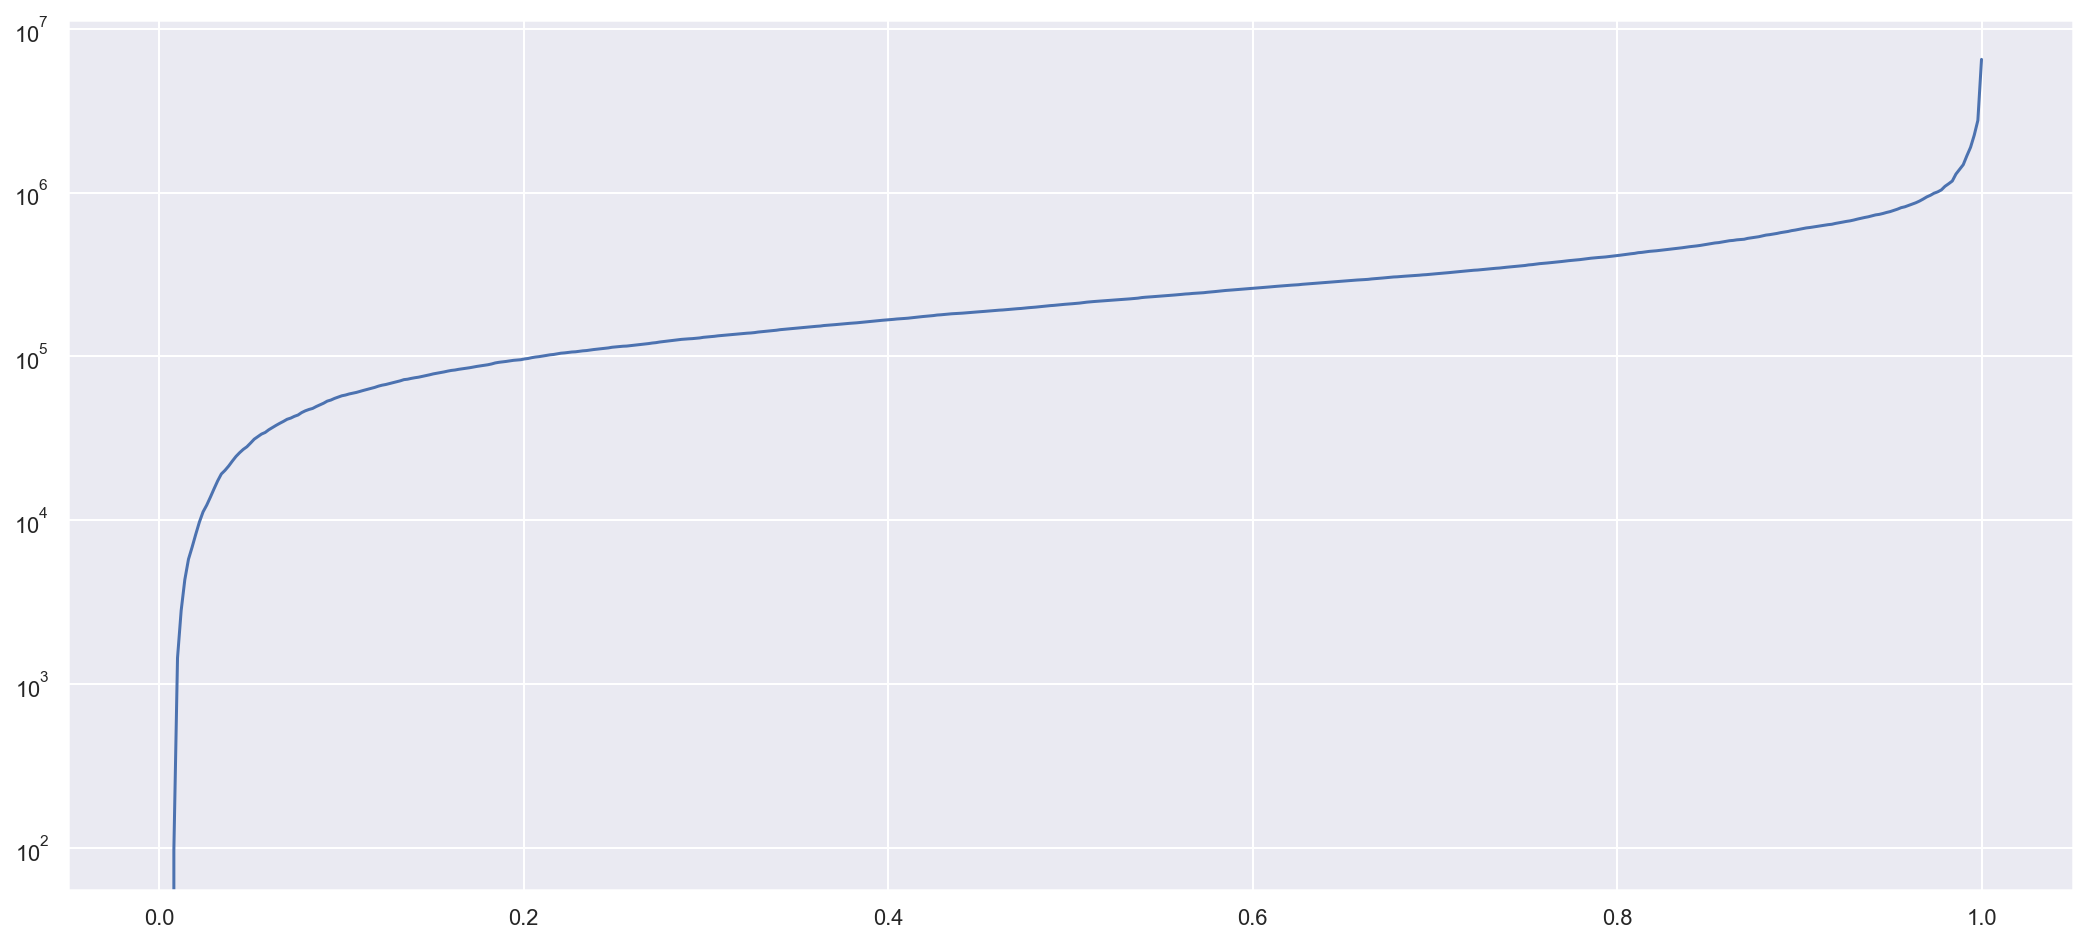

In [25]:
x = np.linspace(0,1,500)
plt.plot(x, [data['Current Credit Balance'].quantile(x) for x in x])
plt.yscale('log')

Вроде бы все нормально

---

**Monthly Debt**

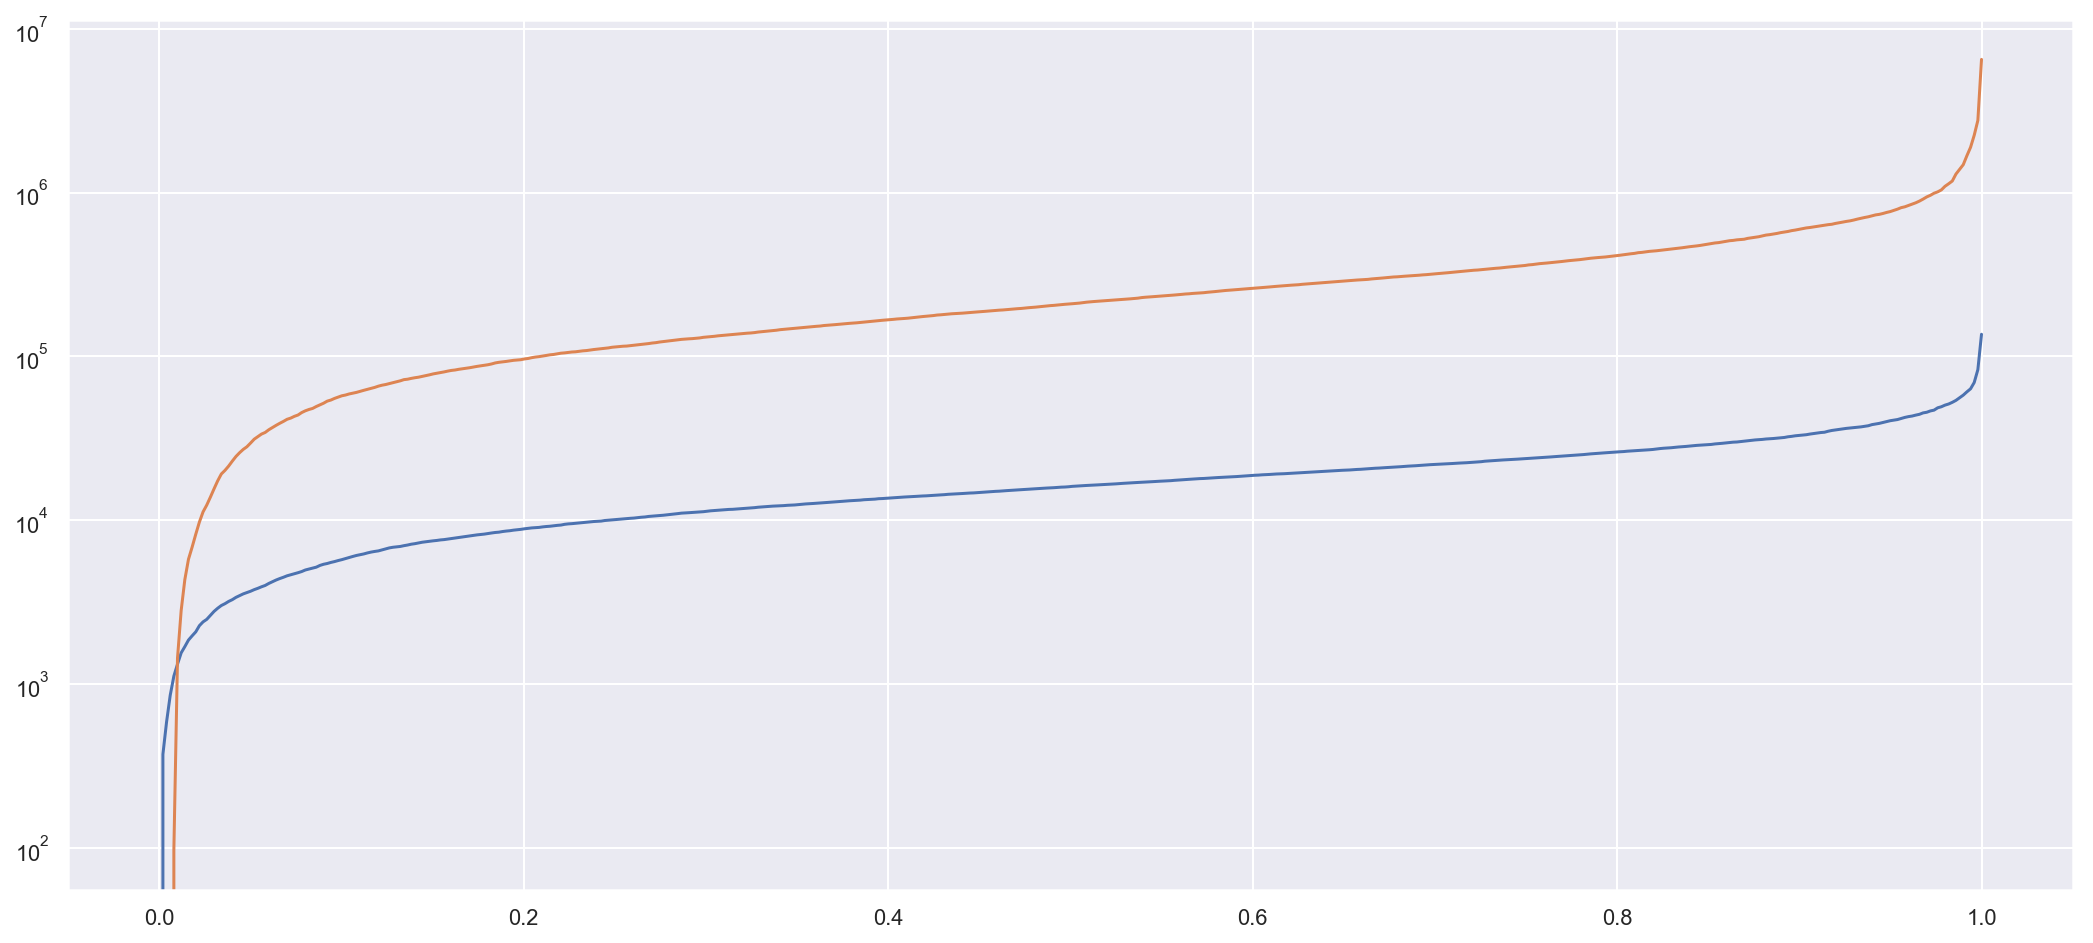

In [26]:
x = np.linspace(0,1,500)
plt.plot(x, [data['Monthly Debt'].quantile(x) for x in x])
plt.plot(x, [data['Current Credit Balance'].quantile(x) for x in x])
plt.yscale('log')

Вроде бы все нормально и данные похожи на Current Credit Balance

---

**Credit Score**

In [27]:
data[data['Credit Score'].isna()].head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
5,5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
8,8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
10,10,Home Mortgage,NaN,< 1 year,0.0,7.0,11.5,256322.0,0.0,NaN,0.0,debt consolidation,Short Term,220858.0,187492.0,14592.0,NaN,0
16,16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1


Признак имеет высокую корреляцию только с целевым признаком, заполнять при помощи него - бесполезно. Заполним пропуски нулями

---

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

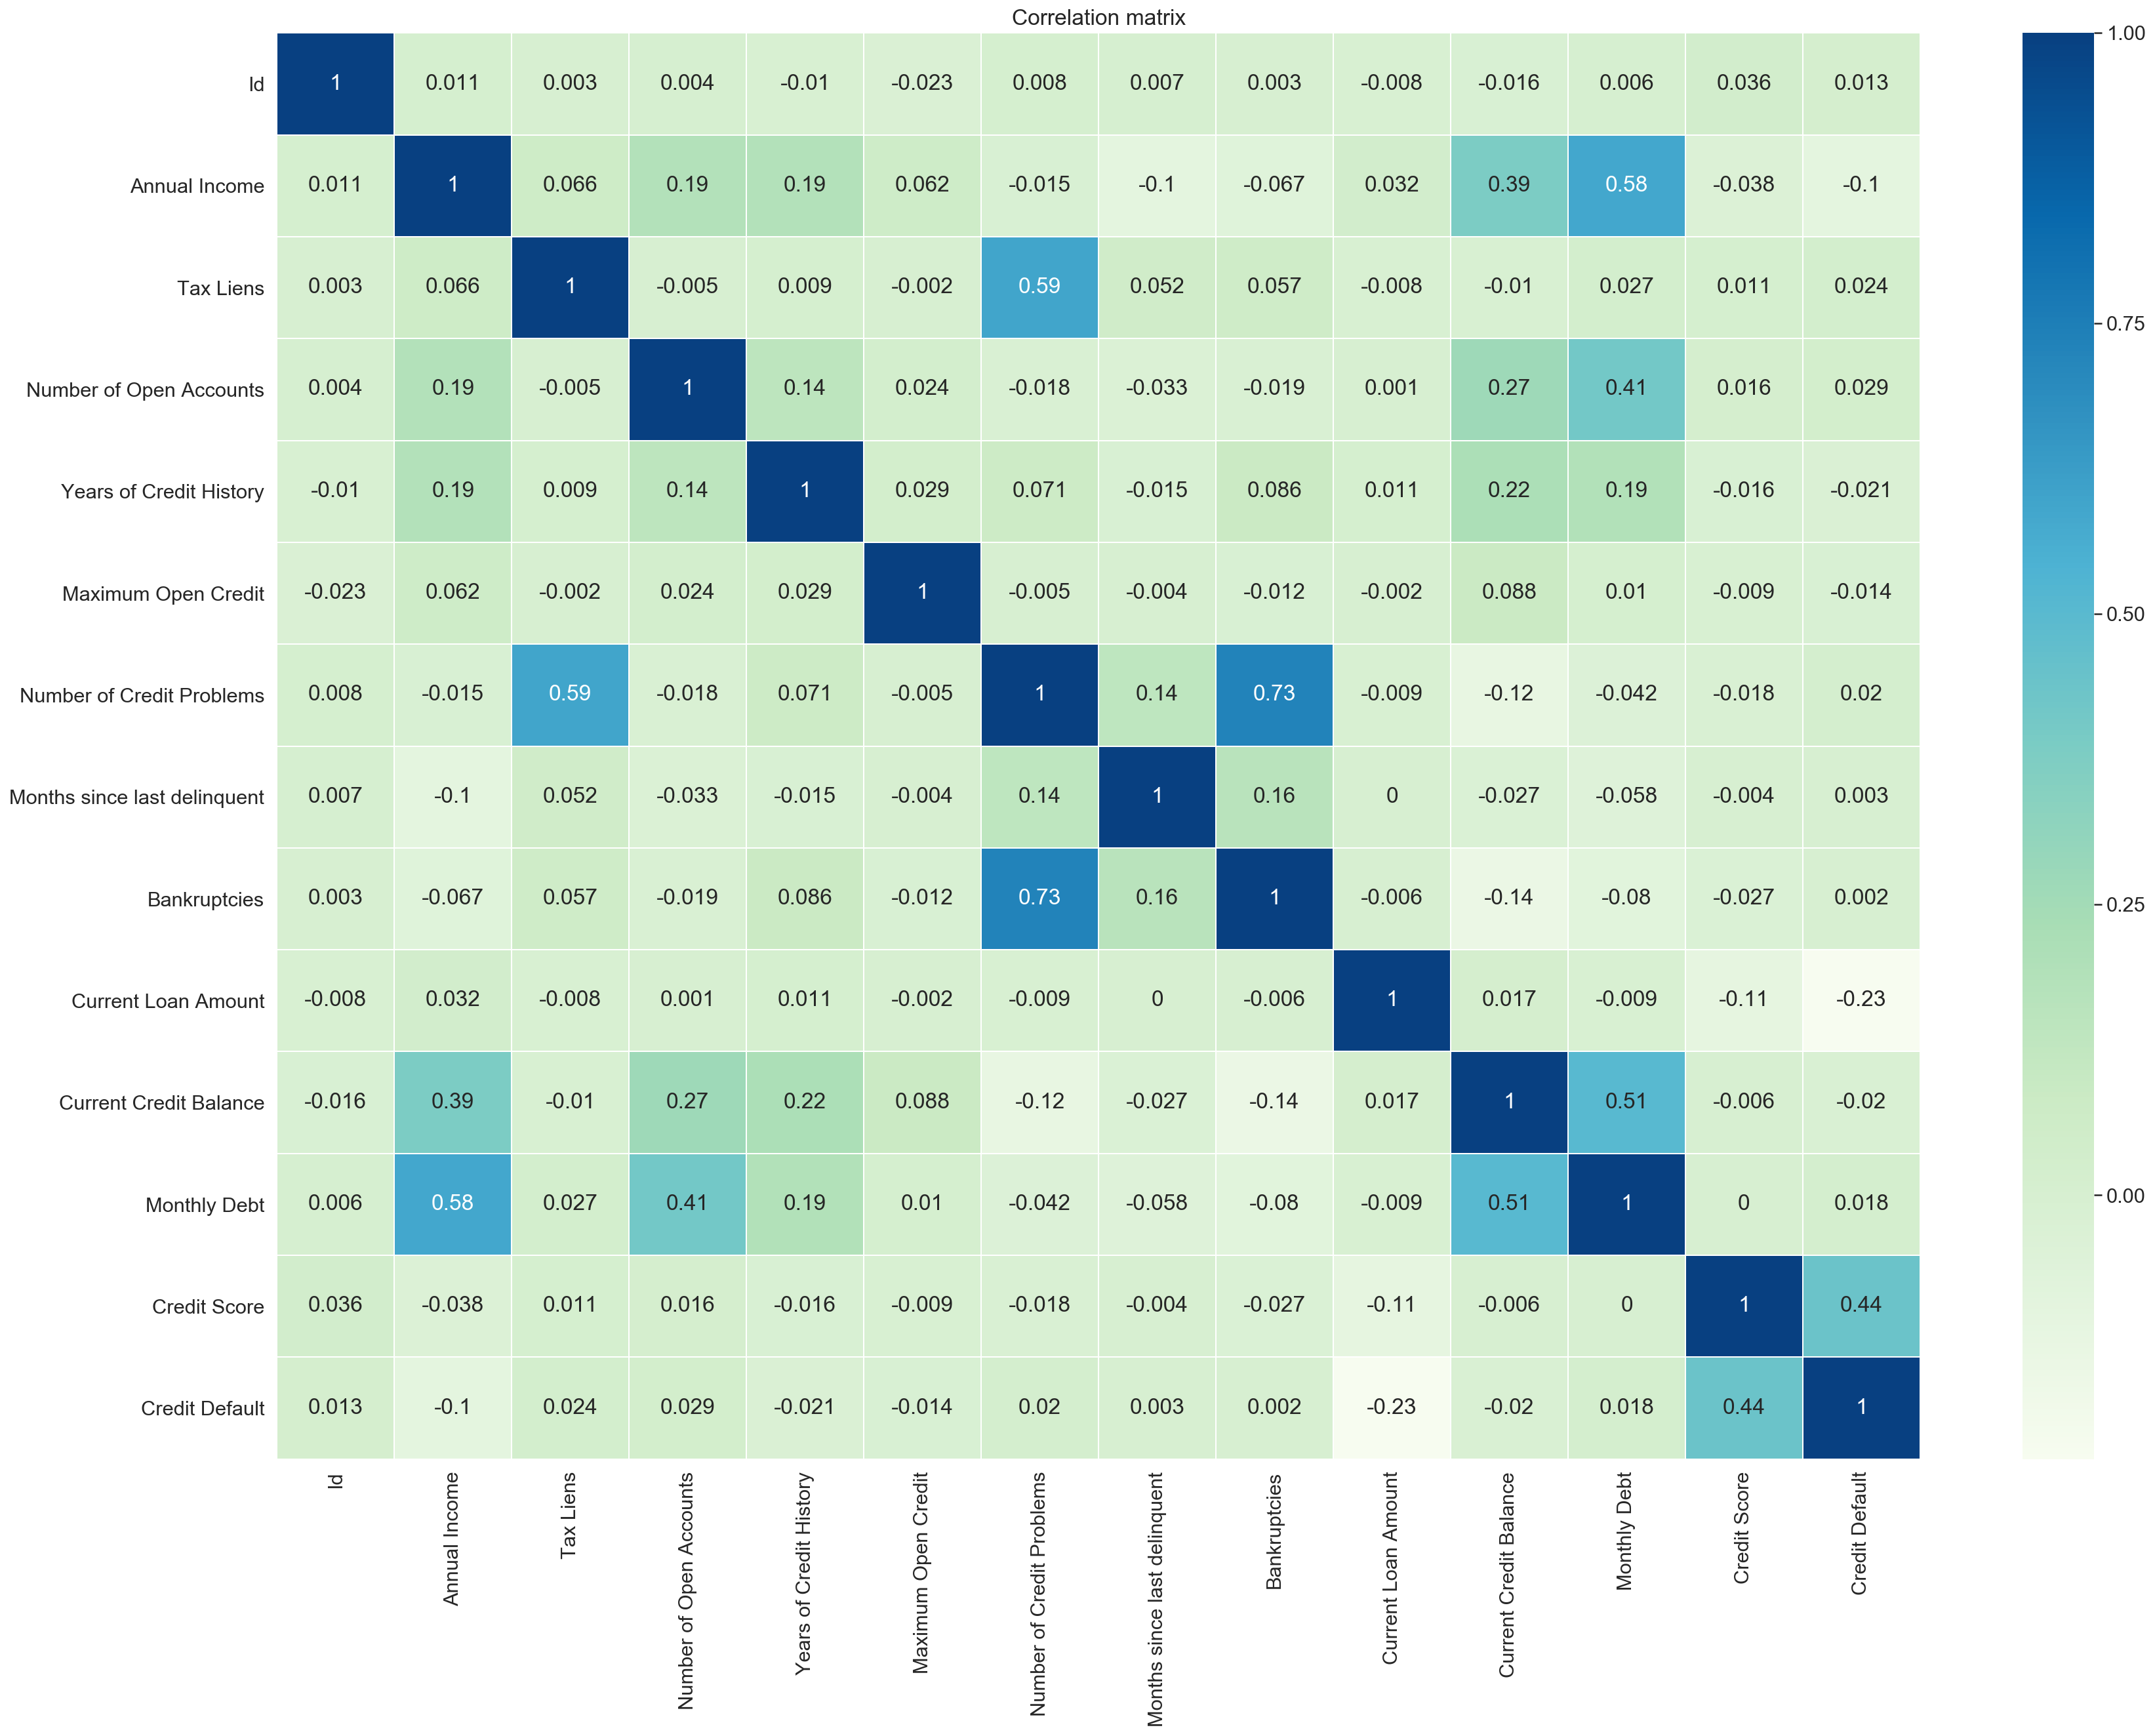

In [28]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(data.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

---

---

## Шаг 3:
***Обработка данных***

In [29]:
data = pd.read_csv('train.csv')
data.shape

(7500, 18)

Вся описанная ранее обработка располагается внутри методов класа Handler.

Вызываем экземпляр этого класса

In [30]:
handler = Handler()

В методе **fit_transform** создаются все переменные для обработки и модель RFR для заполнения Annual Income

In [31]:
handler.fit_transform(data)

Data shape: (7500, 18)
----------------------------------------------------------------------------------------------------
Filling Annual Income

Test sample size: (5943, 5)
Train sample size: (1557, 4)
(4160, 4) (1783, 4) (4160,) (1783,)
r2 score for Annual Income prediction: 0.38972607926913194
----------------------------------------------------------------------------------------------------


Размер подготовленного DataFrame

In [32]:
handler.train_prep.shape

(7500, 44)

---

Загрузим тестовые данные

In [33]:
test = pd.read_csv('test.csv')
test.shape

(2500, 17)

Метод transform заполняет все пропущенные данные в тестовом наборе на основе тренировочного 

In [34]:
handler.transform(test)

Data shape: (2500, 17)


Размер тестового DataFrame

In [35]:
handler.test_prep.shape

(2500, 43)

---

---

## Шаг 4:
***Создание моделей***

Подготовка названия колонок

In [36]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES_SELECTED = handler.train_prep.columns.drop(TARGET_NAME)

Разбиенеие на тестовый и тренировачные датасеты

In [37]:
X = handler.train_prep[FEATURE_NAMES_SELECTED]
y = handler.train_prep[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

Балансировка по целевому признаку

In [38]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
print(df_balanced[TARGET_NAME].value_counts())
X_train = df_balanced.drop(TARGET_NAME, axis=1)
y_train = df_balanced[TARGET_NAME]

0    4047
1    3156
Name: Credit Default, dtype: int64


Создидим 2 модели и для максимизации метрики recall возьмем их комбинацию по положительному признаку

Обучение модели CatBoost на сбалансированных данных

In [39]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

In [40]:
cb_y_train_pred = model_catb.predict(X_train)
cb_y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, cb_y_train_pred, y_test, cb_y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      4047
           1       0.85      0.71      0.77      3156

   micro avg       0.82      0.82      0.82      7203
   macro avg       0.82      0.80      0.81      7203
weighted avg       0.82      0.82      0.81      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1340
           1       0.56      0.52      0.54       535

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1124  216
1                257  278


Обучение модели LGBM на сбалансированных данных

In [41]:
lgbm_best_params = {'num_leaves': 10, 'max_depth': 3, 'max_bin': 50, 'learning_rate': 0.1}

model_lgbm = lgbm.LGBMClassifier(**lgbm_best_params, random_state=21)
model_lgbm.fit(X_train, y_train)

lgbm_y_train_pred = model_lgbm.predict(X_train)
lgbm_y_test_pred = model_lgbm.predict(X_test)
get_classification_report(y_train, lgbm_y_train_pred, y_test, lgbm_y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      4047
           1       0.75      0.60      0.67      3156

   micro avg       0.74      0.74      0.74      7203
   macro avg       0.74      0.72      0.73      7203
weighted avg       0.74      0.74      0.73      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1340
           1       0.56      0.52      0.54       535

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.69      0.68      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1122  218
1                257  278


Комбинация двух моделей

In [42]:
y_train_pred = (lgbm_y_train_pred + cb_y_train_pred)
y_test_pred = (lgbm_y_test_pred + cb_y_test_pred)
y_train_pred[y_train_pred>1] = 1
y_test_pred[y_test_pred>1] = 1
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4047
           1       0.77      0.72      0.75      3156

   micro avg       0.78      0.78      0.78      7203
   macro avg       0.78      0.78      0.78      7203
weighted avg       0.78      0.78      0.78      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      1340
           1       0.53      0.58      0.55       535

   micro avg       0.73      0.73      0.73      1875
   macro avg       0.68      0.68      0.68      1875
weighted avg       0.74      0.73      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1064  276
1                227  308


## Шаг 5:
***Обучение моделей на полных данных***

In [43]:
df_balanced = balance_df_by_target(handler.train_prep, TARGET_NAME)   
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

In [44]:
X = df_balanced[FEATURE_NAMES_SELECTED]
y = df_balanced[TARGET_NAME]

In [45]:
model_lgbm.fit(X, y)
model_catb.fit(X, y)

## Шаг 6:
***Предсказание целевой переменной***

In [46]:
res1 = model_lgbm.predict(handler.test_prep)
res2 = model_catb.predict(handler.test_prep)
res = res1 + res2
res[res>1]=1

In [47]:
final_df = pd.DataFrame({'Id':range(7500, 10000),'Credit Default':res.astype(int)})

In [48]:
final_df.to_csv('ABakulin_predictions.csv', index=False)